In [58]:
import pandas as pd
import requests as req
import sqlite3 as sq
from io import StringIO
from datetime import datetime, timedelta
from time import sleep
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [59]:
BASE_URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv"

DB = "nyc_311_data_ab.db"

BATCH_SIZE = 50000

conn = sq.connect(DB)
cursor = conn.cursor()

#COMMENTED CODE BELOW WILL DELETE ALL HISTORICAL DATA only run if you want this to run as if its running for the first time
#cursor.execute("""DROP TABLE IF EXISTS store_311_service_requests""")
#cursor.execute("""DROP TABLE IF EXISTS store_311_agencies""")

#raw_311_service_requests drop existing table then create new table
cursor.execute("""DROP TABLE IF EXISTS raw_311_service_requests""")

cursor.execute("""CREATE TABLE raw_311_service_requests (
    unique_key TEXT PRIMARY KEY,
    created_date TEXT ,
    closed_date TEXT,
    agency TEXT,
    agency_name TEXT,
    complaint_type TEXT,
    descriptor TEXT,
    location_type TEXT,
    incident_zip TEXT,
    incident_address TEXT,
    street_name TEXT,
    cross_street_1 TEXT,
    cross_street_2 TEXT,
    intersection_street_1 TEXT,
    intersection_street_2 TEXT,
    address_type TEXT,
    city TEXT,
    landmark TEXT,
    facility_type TEXT,
    status TEXT,
    due_date TEXT,
    resolution_description TEXT,
    resolution_action_updated_date TEXT,
    community_board TEXT,
    bbl TEXT,
    borough TEXT,
    x_coordinate_state_plane TEXT,
    y_coordinate_state_plane TEXT,
    open_data_channel_type TEXT,
    park_facility_name TEXT,
    park_borough TEXT,
    vehicle_type TEXT,
    taxi_company_borough TEXT,
    taxi_pick_up_location TEXT,
    bridge_highway_name TEXT,
    bridge_highway_direction TEXT,
    road_ramp TEXT,
    bridge_highway_segment TEXT,
    latitude REAL,
    longitude REAL,
    location TEXT
);
""")

#store_311_service_requests table creation if not already existing (only activates on first run)
cursor.execute("""
CREATE TABLE IF NOT EXISTS store_311_service_requests (
    unique_key TEXT PRIMARY KEY,
    created_date TEXT,
    closed_date TEXT,
    agency TEXT,
    complaint_type TEXT,
    descriptor TEXT,
    location_type TEXT,
    incident_zip TEXT,
    incident_address TEXT,
    street_name TEXT,
    cross_street_1 TEXT,
    cross_street_2 TEXT,
    intersection_street_1 TEXT,
    intersection_street_2 TEXT,
    address_type TEXT,
    city TEXT,
    landmark TEXT,
    facility_type TEXT,
    status TEXT,
    due_date TEXT,
    resolution_description TEXT,
    resolution_action_updated_date TEXT,
    community_board TEXT,
    bbl TEXT,
    borough TEXT,
    x_coordinate_state_plane TEXT,
    y_coordinate_state_plane TEXT,
    open_data_channel_type TEXT,
    park_facility_name TEXT,
    park_borough TEXT,
    vehicle_type TEXT,
    taxi_company_borough TEXT,
    taxi_pick_up_location TEXT,
    bridge_highway_name TEXT,
    bridge_highway_direction TEXT,
    road_ramp TEXT,
    bridge_highway_segment TEXT,
    latitude REAL,
    longitude REAL,
    location TEXT
);
""")

#store_311_agencies table creation if not already existing (only activates on first run)
cursor.execute("""
CREATE TABLE IF NOT EXISTS store_311_agencies (
    agency TEXT PRIMARY KEY,
    agency_name TEXT,
    FOREIGN KEY (agency) REFERENCES store_311_service_requests(agency)
);
""")

#ref_311_request_count_by_agency tabe creation - used in analysis for later questions
conn.execute("""DROP TABLE IF EXISTS ref_311_request_count_by_agency;""")

conn.execute("""
CREATE TABLE ref_311_request_count_by_agency(
    agency TEXT PRIMARY KEY,
    agency_name TEXT,
    total_count_by_agency REAL,
    FOREIGN KEY (agency) REFERENCES store_311_service_requests(agency)
    );
""")

conn.commit()

In [60]:
#find max_created_date and max_resolution_action_updated date to use as an iterative ETL process for pulling data in the future

def get_max_dates():
    """Retrieve latest created/resolution dates from store table."""
    try:
        result = pd.read_sql_query("""
        SELECT 
        MAX(created_date)                       AS max_created_date,
        MAX(resolution_action_updated_date)     AS max_resolution_action_updated_date
        FROM store_311_service_requests;""", conn)
        max_created = result.loc[0, "max_created_date"]
        max_resolution = result.loc[0, "max_resolution_action_updated_date"]
        return max_created, max_resolution
    except Exception:
        return None, None

max_created_date, max_resolution_date = get_max_dates()

In [61]:
#create where_clause to only pull data with a created_date >= max_created_date OR resolution_action_updated_date >= max_resolution_action_updated_date
#if max_resolution_date and max_created_date don't exists (i.e store table empty because this is the first run), then pull trailing 13 months
end_date = datetime.now()
start_date = end_date - timedelta(days=13*30)

if max_created_date or max_resolution_date:
    filters = []
    if max_resolution_date:
        filters.append(
            f"resolution_action_updated_date >= '{max_resolution_date}'")
    if max_created_date:
        filters.append(f"created_date >= '{max_created_date}'")
    where_clause = " OR ".join(filters)
    print(f"Incremental pull:\n{where_clause}")
else:
    where_clause = (
        f"created_date between '{start_date.strftime('%Y-%m-%dT00:00:00')}' "
        f"and '{end_date.strftime('%Y-%m-%dT23:59:59')}'"
    )
    print(f"Initial pull for last 13 months:\n{where_clause}")


Incremental pull:
resolution_action_updated_date >= '2927-03-06T12:30:00.000' OR created_date >= '2025-11-05T03:58:58.000'


In [62]:
#pull data in batches defined by batch size set at beginning and give response on failure

def fetch_311_batch(offset=0, limit=BATCH_SIZE):
    params = {
        "$limit": limit,
        "$offset": offset,
        "$where": where_clause
    }
    response = req.get(BASE_URL, params=params)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed batch (HTTP {response.status_code})")
        return pd.DataFrame()

In [63]:
def insert_to_raw(df):
    for _, row in df.iterrows():
        cursor.execute("""
        INSERT OR IGNORE INTO 'raw_311_service_requests' (
                unique_key,
                created_date,
                closed_date,
                agency,
                agency_name,
                complaint_type,
                descriptor,
                location_type,
                incident_zip,
                incident_address,
                street_name,
                cross_street_1,
                cross_street_2,
                intersection_street_1,
                intersection_street_2,
                address_type,
                city,
                landmark,
                facility_type,
                status,
                due_date,
                resolution_description,
                resolution_action_updated_date,
                community_board,
                bbl,
                borough,
                x_coordinate_state_plane,
                y_coordinate_state_plane,
                open_data_channel_type,
                park_facility_name,
                park_borough,
                vehicle_type,
                taxi_company_borough,
                taxi_pick_up_location,
                bridge_highway_name,
                bridge_highway_direction,
                road_ramp,
                bridge_highway_segment,
                latitude,
                longitude,
                location
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ON CONFLICT (unique_key) DO NOTHING;
        """, 
        (row['unique_key'], row['created_date'], row['closed_date']
        , row['agency'], row['agency_name'],row['complaint_type']
        , row['descriptor'], row['location_type'], row['incident_zip'], row['incident_address']
        , row['street_name'], row['cross_street_1'], row['cross_street_2'], row['intersection_street_1']
        , row['intersection_street_2'], row['address_type'], row['city'], row['landmark']
        , row['facility_type'], row['status'], row['due_date'], row['resolution_description']
        , row['resolution_action_updated_date'], row['community_board'], row['bbl'], row['borough'] 
        , row['x_coordinate_state_plane'], row['y_coordinate_state_plane'], row['open_data_channel_type']
        , row['park_facility_name'], row['park_borough'], row['vehicle_type'], row['taxi_company_borough']
        , row['taxi_pick_up_location'], row['bridge_highway_name'], row['bridge_highway_direction']
        , row['road_ramp'], row['bridge_highway_segment'], row['latitude'], row['longitude'], row['location']))
        
    conn.commit()

In [64]:
#define import_to_raw using fetch_311_batch and keep pulling data until fetch_311_batch is empty (i.e. failed or where_clause prevented any data from being pulled)

def import_to_raw():

    offset = 0
    total_rows = 0

    while True:
        df = fetch_311_batch(offset)
        if df.empty:
            break

        insert_to_raw(df)  # Insert data using INSERT statement
        total_rows += len(df)

        offset += BATCH_SIZE
        sleep(1)

    print(f"Loaded {total_rows:,} total rows into 'raw_311_service_requests'")



In [65]:
import_to_raw()

Loaded 9,880 total rows into 'raw_311_service_requests'


In [66]:
#insert data from the raw table into store_311_service_requests and store_311_agencies

conn.execute("""
INSERT OR REPLACE INTO store_311_service_requests (
    unique_key,
    created_date,
    closed_date,
    agency,
    complaint_type,
    descriptor,
    location_type,
    incident_zip,
    incident_address,
    street_name,
    cross_street_1,
    cross_street_2,
    intersection_street_1,
    intersection_street_2,
    address_type,
    city,
    landmark,
    facility_type,
    status,
    due_date,
    resolution_description,
    resolution_action_updated_date,
    community_board,
    bbl,
    borough,
    x_coordinate_state_plane,
    y_coordinate_state_plane,
    open_data_channel_type,
    park_facility_name,
    park_borough,
    vehicle_type,
    taxi_company_borough,
    taxi_pick_up_location,
    bridge_highway_name,
    bridge_highway_direction,
    road_ramp,
    bridge_highway_segment,
    latitude,
    longitude,
    location
)
SELECT
    unique_key,
    created_date,
    closed_date,
    agency,
    complaint_type,
    descriptor,
    location_type,
    incident_zip,
    incident_address,
    street_name,
    cross_street_1,
    cross_street_2,
    intersection_street_1,
    intersection_street_2,
    address_type,
    city,
    landmark,
    facility_type,
    status,
    due_date,
    resolution_description,
    resolution_action_updated_date,
    community_board,
    bbl,
    borough,
    x_coordinate_state_plane,
    y_coordinate_state_plane,
    open_data_channel_type,
    park_facility_name,
    park_borough,
    vehicle_type,
    taxi_company_borough,
    taxi_pick_up_location,
    bridge_highway_name,
    bridge_highway_direction,
    road_ramp,
    bridge_highway_segment,
    latitude,
    longitude,
    location
FROM raw_311_service_requests;
"""
)

conn.execute("""
INSERT OR REPLACE INTO store_311_agencies (
    agency,
    agency_name
    )
SELECT DISTINCT
    agency,
    agency_name
FROM raw_311_service_requests;
"""
)

conn.execute("""
INSERT INTO ref_311_request_count_by_agency (
    agency,
    agency_name,
    total_count_by_agency
    )
SELECT DISTINCT
    sr.agency,
    a.agency_name,
    count(*) AS total_count_by_agency
FROM store_311_service_requests sr
LEFT JOIN store_311_agencies a
    ON sr.agency = a.agency
GROUP BY 
    sr.agency,
    a.agency_name;
""")

conn.commit()

In [ ]:
#Question 1: How many service requests are status = closed with no resolution or status <> closed with a resolution and is it concentrated on any particular agency?
#Notes - checked resolution fields and saw that sometimes it had a resolution_action_updated_date but no resolution_description

Question1 = pd.read_sql_query("""
SELECT DISTINCT
    a.agency_name,
    CASE sr.status = 'Closed'
        WHEN  True THEN 'Closed'
        ELSE 'Not Closed'
    END AS status_closed,
    CASE resolution_action_updated_date IS NULL
        WHEN  True THEN 'Unresolved'
        ELSE 'Resolved'
    END AS Resolved,
    count(*) AS Count,
    total_count_by_agency,
    CAST(count(*)/total_count_by_agency AS TEXT) AS percent_of_total_count
FROM store_311_service_requests sr
LEFT JOIN store_311_agencies a
    ON sr.agency = a.agency
LEFT JOIN ref_311_request_count_by_agency ac
    ON sr.agency = ac.agency
WHERE (resolution_action_updated_date IS NULL
    AND Status = 'Closed')
    OR
    (Status <> 'Closed'
    AND resolution_action_updated_date IS NOT NULL)
GROUP BY 
    a.agency_name,
    CASE resolution_action_updated_date IS NULL
        WHEN  True THEN 'Unresolved'
        ELSE 'Resolved'
    END,
    CASE sr.status = 'Closed'
        WHEN  True THEN 'Closed'
        ELSE 'Not Closed'
    END
""", conn)

print("How many service requests are status = closed with no resolution or status <> closed with a resolution and is it concentrated on any particular agency?")
print("""Per the below table, Department of Buildings has 21,524 requests that are not closed but marked resolved, making up 20 percent of their total request count
Additionally, the Department of Parks and Recreation has a significant number of requests In Progress while marked Resolved""")
print(Question1)

How many service requests are status = closed with no resolution or status <> closed with a resolution and is it concentrated on any particular agency?
Per the below table, Department of Buildings has 21,524 requests that are not closed but marked resolved, making up 20 percent of their total request count
Additionally, the Department of Parks and Recreation has a significant number of requests In Progress while marked Resolved


,agency_name,status_closed,Resolved,Count,total_count_by_agency,percent_of_total_count
0,Department of Buildings,Not Closed,Resolved,43560,216754.0,0.200965149432075
1,Department of Consumer and Worker Protection,Not Closed,Resolved,1248,39216.0,0.0318237454100367
2,Department of Education,Not Closed,Resolved,6,3836.0,0.00156412930135558
3,Department of Environmental Protection,Not Closed,Resolved,31174,2900144.0,0.0107491214229362
4,Department of Health and Mental Hygiene,Not Closed,Resolved,6950,181652.0,0.0382599696122256
5,Department of Homeless Services,Not Closed,Resolved,848,113648.0,0.00746163592848092
6,Department of Housing Preservation and Develop...,Not Closed,Resolved,57720,1417508.0,0.0407193469102114
7,Department of Parks and Recreation,Not Closed,Resolved,33968,236566.0,0.143587835952757
8,Department of Parks and Recreation,Closed,Unresolved,2,236566.0,8.45430027983734e-06
9,Department of Sanitation,Not Closed,Resolved,10848,1036299.0,0.0104680212950123


In [ ]:
#Question 2: How many service requests are there with status = closed and no closed date or status <> closed and have a closed date and is it concentrated on any particular agency?

Question2 = pd.read_sql_query("""
SELECT DISTINCT
    a.agency_name,
    CASE sr.status = 'Closed'
        WHEN  True THEN 'Closed'
        ELSE 'Not Closed'
    END AS status_closed,
    CASE closed_date IS NULL
        WHEN  True THEN 'No Closed Date'
        ELSE 'Closed Date Present'
    END AS closed_date_present,
    count(*) AS Count,
    total_count_by_agency,
    CAST(count(*)/total_count_by_agency AS TEXT) AS percent_of_total_count
FROM store_311_service_requests sr
LEFT JOIN store_311_agencies a
    ON sr.agency = a.agency
LEFT JOIN ref_311_request_count_by_agency ac
    ON sr.agency = ac.agency
WHERE (closed_date IS NULL
    AND Status = 'Closed')
    OR
    (closed_date IS NOT NULL
    AND Status <> 'Closed')
GROUP BY 
    a.agency_name,
    CASE sr.status = 'Closed'
        WHEN  True THEN 'Closed'
        ELSE 'Not Closed'
    END,
    CASE closed_date IS NULL
        WHEN  True THEN 'No Closed Date'
        ELSE 'Present Closed Date'
    END
""", conn)

print("How many service requests are there with status = closed and no closed date or status <> closed and have a closed date and is it concentrated on any particular agency?")
print("""Per the below table, Department of Buildings has 21,524 requests that are not closed but have a closed date, making up 20 percent of their total request count
these are likely the same requests that are also marked resolved, meaning the Status field should be updated for these - checking the status field, they are either Open or Assigned.
Additionally, the Department of Homeless Services has a 20 percent of requests Closed with no Closed Date""")
print(Question2)


How many service requests are there with status = closed and no closed date or status <> closed and have a closed date and is it concentrated on any particular agency?
Per the below table, Department of Buildings has 21,524 requests that are not closed but have a closed date, making up 20 percent of their total request count
these are likely the same requests that are also marked resolved, meaning the Status field should be updated for these - checking the status field, they are either Open or Assigned.
Additionally, the Department of Homeless Services has a 20 percent of requests Closed with no Closed Date


,agency_name,status_closed,closed_date_present,Count,total_count_by_agency,percent_of_total_count
0,Department of Buildings,Not Closed,Closed Date Present,43560,216754.0,0.200965149432075
1,Department of Consumer and Worker Protection,Not Closed,Closed Date Present,2,39216.0,5.0999592003264e-05
2,Department of Environmental Protection,Not Closed,Closed Date Present,598,2900144.0,0.000206196657821129
3,Department of Health and Mental Hygiene,Not Closed,Closed Date Present,56,181652.0,0.000308281769537357
4,Department of Homeless Services,Closed,No Closed Date,23160,113648.0,0.203787132197663
5,Department of Housing Preservation and Develop...,Not Closed,Closed Date Present,20,1417508.0,1.41092678136561e-05
6,Department of Parks and Recreation,Not Closed,Closed Date Present,12,236566.0,5.0725801679024e-05
7,Department of Sanitation,Closed,No Closed Date,126,1036299.0,0.000121586530528351
8,Department of Sanitation,Not Closed,Closed Date Present,24,1036299.0,2.31593391482574e-05
9,Department of Transportation,Not Closed,Closed Date Present,22360,2925741.0,0.00764250834233105


In [ ]:
#Question 3: Which Agency has the most non-closed service requests, and of the non-closed, how many are unspecified or open?

Question3 = pd.read_sql_query("""
SELECT DISTINCT
    a.agency_name,
    sr.status,
    count(*) AS Count,
    total_count_by_agency,
    CAST(count(*)/total_count_by_agency AS TEXT) AS percent_of_total_count
FROM store_311_service_requests sr
LEFT JOIN store_311_agencies a
    ON sr.agency = a.agency
LEFT JOIN ref_311_request_count_by_agency ac
    ON sr.agency = ac.agency
WHERE 
    sr.Status <> 'Closed'
GROUP BY
    a.agency_name,
    sr.status
""", conn)

print("""Which Agency has the most non-closed service requests, and of the non-closed, how many are unspecified or open?""")
print("""Per the below table, the 21,524 problem service requests from the Department of Buildings in the prior two tests have appeared again.
Additionally, the Department of Health and MEntal Hygiene has 11 percent of requets non-closed, however most of them are in progress.
Economic Development Corporation has 75 percent of requests non-closed, however they are all In Progress. 
Thankfully, no agency has a significant percent of requests sitting open or unspecified""")
print(Question3)

Which Agency has the most non-closed service requests, and of the non-closed, how many are unspecified or open?
Per the below table, the 21,524 problem service requests from the Department of Buildings in the prior two tests have appeared again.
Additionally, the Department of Health and MEntal Hygiene has 11 percent of requets non-closed, however most of them are in progress.
Economic Development Corporation has 75 percent of requests non-closed, however they are all In Progress. 
Thankfully, no agency has a significant percent of requests sitting open or unspecified
                      agency_name                        status     Count  total_count_by_agency percent_of_total_count
0                             Department of Buildings     Assigned  18456         216754.0          0.0851472175830665 
1                             Department of Buildings         Open  25104         216754.0           0.115817931849009 
2        Department of Consumer and Worker Protection  In Progres

In [51]:
#Question 4: On average how long does it take from created_date to closed_date by agency? PYTHON

conn = sq.connect(DB)

df = pd.read_sql_query("""
SELECT
    agency_name,
    created_date,
    closed_date
FROM store_311_service_requests sr
LEFT JOIN store_311_agencies a
    ON a.agency = sr.agency
WHERE 
    created_date IS NOT NULL
    AND closed_date IS NOT NULL
    AND agency_name IS NOT NULL;
""", conn)
conn.close()

df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")

df = df.dropna(subset=["created_date", "closed_date"])

df["days_to_close"] = (df["closed_date"] - df["created_date"]).dt.total_seconds() / (24 * 3600)

df = df[df["days_to_close"] >= 0]
df = df[df["days_to_close"] < 3650]

Question4 = (
    df.groupby("agency_name")["days_to_close"]
    .agg(
        avg_days_to_close="mean",
        std_days_to_close="std",
        count="count"
    )
    .reset_index()
)

Question4["avg_days_to_close"] = Question4["avg_days_to_close"].round(2)
Question4["std_days_to_close"] = Question4["std_days_to_close"].round(2)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

print("On average how long does it take from created_date to closed_date by agency?")
print(""""Per the below table, the Department of Building, Department of Parks and Recreation, and Taxi and Limousine Commission have high avg_days_to_close
and significant standard deviation. Additionally, the Office of the Sheriff, Economic Development Corporation, and Department of Education have high avg_days_to_close,
however they have a significantly smaller sample size""")
print(Question4)

On average how long does it take from created_date to closed_date by agency?
"Per the below table, the Department of Building, Department of Parks and Recreation, and Taxi and Limousine Commission have high avg_days_to_close
and significant standard deviation. Additionally, the Office of the Sheriff, Economic Development Corporation, and Department of Education have high avg_days_to_close,
however they have a significantly smaller sample size
                      agency_name                      avg_days_to_close  std_days_to_close   count 
0                             Department of Buildings        29.39              53.42         108098
1        Department of Consumer and Worker Protection        12.25              14.56          18813
2                             Department of Education        29.01              37.86           1199
3              Department of Environmental Protection         4.06               9.26        2591976
4             Department of Health and Mental Hy

How many service requests come per month, per borough, and does one borough stand out?
Per the chart below, requests are relatively distributed by month, with a slight spike in January 25 (potentially from holiday backlog).
Most requests are for Queens and Brooklyn, with the Bronx having a spike in January 25


<Figure size 1200x600 with 0 Axes>

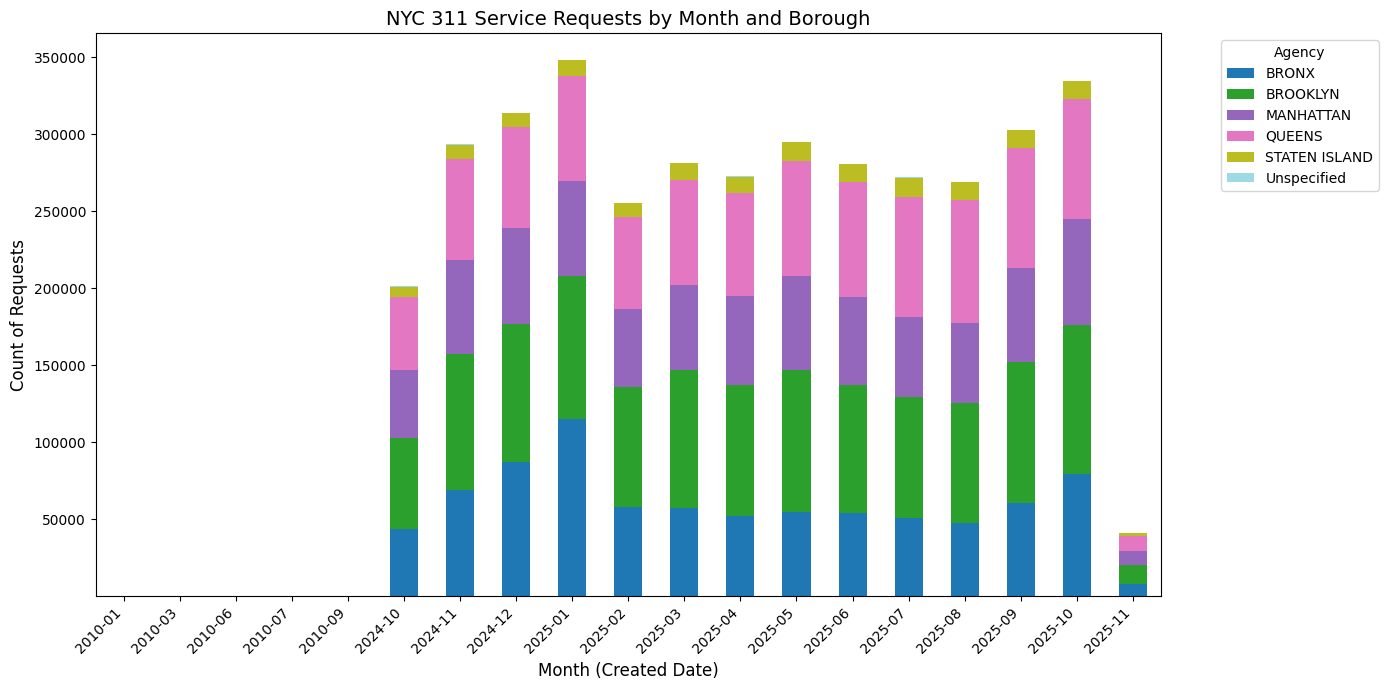

In [54]:
#Question 5: How many service requests come per month, per borough, and does one borough stand out? PYTHON

conn = sq.connect(DB)

df = pd.read_sql_query("""
SELECT
    borough,
    created_date
FROM store_311_service_requests sr
WHERE 
    created_date IS NOT NULL;
""", conn)
conn.close()

df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")

df = df.dropna(subset=["created_date"])

df["month"] = df["created_date"].dt.to_period("M").astype(str)

counts = (
    df.groupby(["month", "borough"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
counts.plot(kind="bar", stacked=True, colormap="tab20", figsize=(14, 7))

print("How many service requests come per month, per borough, and does one borough stand out?")
print("""Per the chart below, requests are relatively distributed by month, with a slight spike in January 25 (potentially from holiday backlog).
Most requests are for Queens and Brooklyn, with the Bronx having a spike in January 25""")

plt.title("NYC 311 Service Requests by Month and Borough", fontsize=14)
plt.xlabel("Month (Created Date)", fontsize=12)
plt.ylabel("Count of Requests", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Agency", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()